# Decision Trees and Ensemble Learning (Credit Risk Scoring)

We are going to use this [Dataset](https://github.com/gastonstat/CreditScoring/blob/master/CreditScoring.csv) 


In [33]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

# Data Cleaning and Preparation

- Download the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [34]:
df_full = pd.read_csv('CreditScoring.csv')
df_full.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [35]:
# We can lowercase the columns
df_full.columns = df_full.columns.str.lower()
df_full.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [36]:
# And we notice the categorical variables are encoded as numbers so we need to re-encode them.
# This is the r code
# levels(dd$Status) = c("good", "bad")
# levels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")
# levels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")
# levels(dd$Records) = c("no_rec", "yes_rec")
# levels(dd$Job) = c("fixed", "partime", "freelance", "others")

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df_full.status = df_full.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df_full.home = df_full.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df_full.marital = df_full.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df_full.records = df_full.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df_full.job = df_full.job.map(job_values)

df_full.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [37]:
df_full.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [38]:
# We notice there are columns with 99999999, this are unknown values so we replace them with nan
for c in ['income', 'assets', 'debt']:
    df_full[c] = df_full[c].replace(to_replace=99999999, value=np.nan)

In [39]:
df_full.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [40]:
# Remove the unknown values from the status (because this is the y we are trying to predict so we don't need the unknown values)
df_full = df_full[df_full.status != 'unk'].reset_index(drop=True)

In [41]:
# Divide the dataset into train, validation and test
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [42]:
# Reset indexes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [43]:
# Encode the y values into 0 and 1
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values


In [44]:
# Delete the y from data sets
del df_train['status']
del df_val['status']
del df_test['status']

In [45]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


In [46]:
df_val.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,6,rent,36,31,separated,no,fixed,49,140.0,0.0,0.0,550,999
1,18,rent,60,38,married,no,fixed,56,108.0,0.0,0.0,1000,1307
2,17,rent,24,40,married,yes,fixed,58,128.0,0.0,0.0,700,982
3,2,other,48,29,married,no,fixed,75,96.0,6000.0,3000.0,1200,1521
4,25,rent,42,61,married,no,fixed,57,121.0,0.0,0.0,750,830


In [47]:
y_train[:5]

array([1, 1, 0, 1, 0])

# Decision Trees

* How a decision tree looks like
* Training a decision tree
* Overfitting
* Controlling the size of a tree

In [48]:
# A decision tree is like a bunch of if and elses
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [49]:
# We can take a client
xi = df_train.iloc[0].to_dict()
xi

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [50]:
# And our tree will give us a result
assess_risk(xi)

'ok'

### Training

In [51]:
# For training we will need the DecisionThreeClassifier and the DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
# To score our model we will use the area under the curve
from sklearn.metrics import roc_auc_score

In [52]:
# We transform our training dataset to a dictionary
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [53]:
# And fit_trainsform with the DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [54]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]])

In [55]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [56]:
# Now we train the DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [57]:
# Next we will ONLY TRANSFORM (Not fit_transform) our validation dataset
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [58]:
# And we get our predictions
y_pred = dt.predict_proba(X_val)[:, 1]

In [59]:
# Score the model
roc_auc_score(y_val, y_pred)

np.float64(0.6589511031459641)

In [64]:
# And if we predict with te training data we notice we are overfitting
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)

## Overfitting

The roc_auc_score for the validation dataset is 0.65 and the roc_auc_score for the train dataset is 1.0 this is overfitting.

Memorizing the data but fails to generalize.

This can happen because the model is training too deep into de decision tree. So we would want to control how deep the training goes.

We might want to train with a depth of 3

A decision tree with depth of 1 is called a decision stump



In [91]:
# We train our decision tree again with a max_depth of 3
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [92]:
# And we can check the area under the curve again
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print("train:", auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("val:", auc)

train: 0.7761016984958594
val: 0.7389079944782155


In [93]:
# This function let's us print the rules the decision tree learned
from sklearn.tree import export_text

In [94]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



# Decision tree learning algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [96]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]
df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [100]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [108]:
data = []

for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    misclassification_rate_left = round(len(df_left[df_left.status == 'ok'])/len(df_left), 2)
    misclassification_rate_right = round(len(df_right[df_right.status == 'default'])/len(df_right), 2)
    misclassification_avg = round((misclassification_rate_left + misclassification_rate_right) / 2, 2)
    data.append([T, 'default', misclassification_rate_left, 'ok', misclassification_rate_right, misclassification_avg])

    print(T)

pd.DataFrame(data, columns=['T', 'decision left', 'impurity left', 'decision right', 'impurity right', 'avg'])

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64
0
2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
2000
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64
3000
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
4000
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
5000
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64
8000


,T,decision left,impurity left,decision right,impurity right,avg
0,0,default,0.00,ok,0.43,0.21
1,2000,default,0.00,ok,0.33,0.17
2,3000,default,0.00,ok,0.20,0.10
3,4000,default,0.25,ok,0.25,0.25
4,5000,default,0.50,ok,0.50,0.50
5,8000,default,0.43,ok,0.00,0.21


In [109]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default'],
]
df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [110]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

for feature, Ts in thresholds.items():
    print("###################")
    print(feature)
    data = []

    for T in Ts:
        print(T)
        df_left = df_example[df_example.assets <= T]
        df_right = df_example[df_example.assets > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        misclassification_rate_left = round(len(df_left[df_left.status == 'ok'])/len(df_left), 2)
        misclassification_rate_right = round(len(df_right[df_right.status == 'default'])/len(df_right), 2)
        misclassification_avg = round((misclassification_rate_left + misclassification_rate_right) / 2, 2)
        data.append([T, 'default', misclassification_rate_left, 'ok', misclassification_rate_right, misclassification_avg])
        print()

    display(pd.DataFrame(data, columns=['T', 'decision left', 'impurity left', 'decision right', 'impurity right', 'avg']))
    print("###################")


###################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64



,T,decision left,impurity left,decision right,impurity right,avg
0,0,default,0.00,ok,0.43,0.21
1,2000,default,0.00,ok,0.33,0.17
2,3000,default,0.00,ok,0.20,0.10
3,4000,default,0.25,ok,0.25,0.25
4,5000,default,0.50,ok,0.50,0.50
5,8000,default,0.43,ok,0.00,0.21


###################
###################
debt
500


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64



,T,decision left,impurity left,decision right,impurity right,avg
0,500,default,0.0,ok,0.43,0.21
1,1000,default,0.0,ok,0.43,0.21
2,2000,default,0.0,ok,0.33,0.17


###################


### Finding the best split algorithm

```
FOR F IN FEATURES:
    FIND ALL THRESHOLDS FOR F
    FOR T IN THRESHOLDS:
        SPLIT DATASET USING "F>T" CONDITION
        COMPUTE THE IMPURITY OF THIS SPLIT
SELECT THE CONDITION WITH THE LOWEST IMPURITY
```

### STOPPING CRITERIA

* Group is already pure (Doesnt' make sense to split a pure that is already pure)
* Tree reached depth limit
* Group is too small to split (We set a min size of a group if it is too small we can't split it)

### Decision tree learning algorithm

```
FIND_THE_BEST_SPLIT
STOP IF MAX_DEPTH IS REACHED
IF LEFT IS SUFFICIENTLY LARGE AND NOT PURE:
    REPEAT FOR LEFT
IF RIGHT IS SUFFICIENTLY LARGE AND NOT PURE:
    REPEAT FOR RIGHT
```

[To read more about how this work read this](https://scikit-learn.org/1.5/modules/tree.html#classification-criteria)

# Decision Trees Parameter Tuning

* Selecting `max_depth`
* Selecting `min_samples_leaf`

In [111]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.745
  10 -> 0.695
  15 -> 0.657
  20 -> 0.652
None -> 0.646


We can see the best depth is between 4 and 6. We should probably go with 4 because the decision tree will be simpler this way.

In [113]:
scores = []

for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append([d, s, auc])

df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
22,6,15,0.785095
21,6,10,0.777521
24,6,100,0.776434
23,6,20,0.774279
14,5,20,0.774028
13,5,15,0.772142
25,6,200,0.768267
11,5,5,0.768173
9,5,1,0.766938
10,5,2,0.766938


In [118]:
df_scores_pivot = df_scores.pivot_table(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot

auc                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.761283  0.766938  0.750836
2                 0.761283  0.766938  0.766580
5                 0.761283  0.768173  0.759636
10                0.761283  0.762276  0.777521
15                0.763726  0.772142  0.785095
20                0.760910  0.774028  0.774279
100               0.755937  0.763384  0.776434
200               0.747260  0.759073  0.768267
500               0.679842  0.679842  0.679842

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

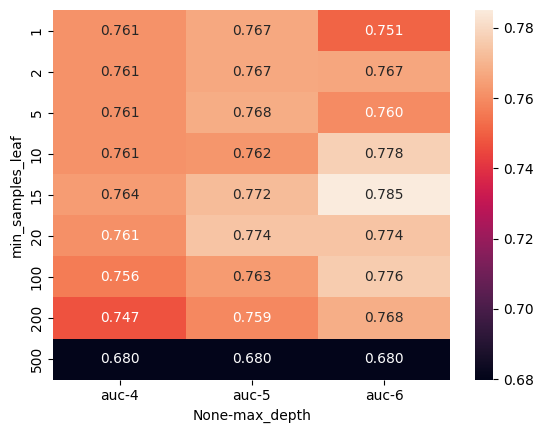

In [120]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

The case is that the best parameters are:
* max_depth = 6
* min_samples_leaf = 15

This way fo looking for the best parameters might be suboptimal, because the dataset is small we can try different combinations (it might be difficult to try every combination)

In [122]:
# This is the one we are going with
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)